In [4]:
import os
import pandas as pd
from ModularCirc import BatchRunner
import torch
import matplotlib.pyplot as plt
from autoemulate.core.types import TensorLike


from comparative_gsa.utils import helpers
figsize = (9, 5)

# Load the necessary files

In [5]:
param_filename = 'parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas'

n_samples_simulations = 245760

simulation_out_path = f'../outputs/simulations/output_{n_samples_simulations}_samples_{param_filename}/'

output_to_emulate = 'p_la_max'

n_samples_emulator = 2048
emulators_path = os.path.join(f'../outputs/simulations/output_{n_samples_emulator}_samples_{param_filename}', 
                              'emulators',
                              output_to_emulate)

parameters_json_file = os.path.join(os.path.join(f'../outputs/simulations/output_{n_samples_emulator}_samples_{param_filename}'), 'parameters.json')


In [6]:
# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(simulation_out_path, f'input_samples_{n_samples_simulations}.csv'))

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(simulation_out_path, f'simulations_summary.csv'))

# Load the trained emulator
ae_results = helpers.ae_load_result(os.path.join(emulators_path, 'MLP_0_20250820_162654'))

In [7]:
ae_results.metadata_df()

,id,model_name,x_transforms,y_transforms,params,r2_test,rmse_test,r2_test_std,rmse_test_std,r2_train,rmse_train,r2_train_std,rmse_train_std
0,0,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 100, 'layer_dims': [16, 8], 'lr': 0...",0.994401,0.774441,0.000693,0.032139,0.996287,0.68144,0.000192,0.007796


In [8]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.k_pas': (0.00666, 0.03),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.k_pas': (0.00666, 0.03)}

In [9]:
# Get column names for parameters up to 'lv.k_pas'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('lv.k_pas') + 1])

input_params[parameter_names]

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.k_pas,lv.E_pas,lv.E_act,lv.k_pas
0,305.576111,0.364705,1047.778645,2.796825,7.379755,116.738799,5.767604,3.872886,0.253016,0.650535,0.027086,1.247329,3.465806,0.025985
1,224.490389,0.267449,1391.318553,3.568193,9.100033,91.786620,6.305379,4.954608,0.372932,0.446568,0.008090,0.806839,2.924290,0.006675
2,254.249478,0.327790,906.121586,2.608205,10.275423,104.035536,5.166425,4.290832,0.334445,0.542466,0.017685,0.985828,3.109324,0.020852
3,271.680109,0.230533,1251.458715,3.003151,8.699872,129.094902,6.925526,3.321711,0.286747,0.613231,0.020454,1.052777,2.523997,0.013266
4,285.041178,0.313907,1283.209757,3.239476,7.965886,122.133654,4.714354,4.508952,0.315288,0.459171,0.014723,1.100807,3.203127,0.011534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245755,285.033139,0.232307,869.958782,3.598806,7.156085,123.430256,7.025206,3.661466,0.296717,0.604820,0.008281,1.152887,3.091918,0.012650
245756,271.687933,0.310963,1112.647238,3.459350,7.819829,130.405363,4.638209,4.907856,0.305319,0.449724,0.026990,1.200916,2.272114,0.012196
245757,254.241680,0.255857,1334.972963,2.928563,9.470156,105.345997,7.475790,3.955657,0.278163,0.653690,0.011161,0.760542,3.373108,0.028487
245758,224.498434,0.349049,973.054563,3.269997,10.538172,89.597974,5.616133,3.207814,0.241430,0.558380,0.013051,0.938978,2.801173,0.017319


In [10]:
Y = summary_stats[output_to_emulate].values

In [11]:
# Turn x into a pytorch tensor
x = torch.tensor(input_params[parameter_names].values, dtype=torch.float32)

# Do the same with Y
y = torch.tensor(Y, dtype=torch.float32)

In [12]:
print(x.shape, y.shape)

torch.Size([245760, 14]) torch.Size([245760])


In [13]:
# Use the input file to predict with the emulator
y_pred = ae_results.model.predict(x)

In [14]:
isinstance(y_pred, TensorLike)

True

In [15]:
# Turning the y_pred into numpy
y_pred_np = y_pred.detach().cpu().numpy()

# Do the plots

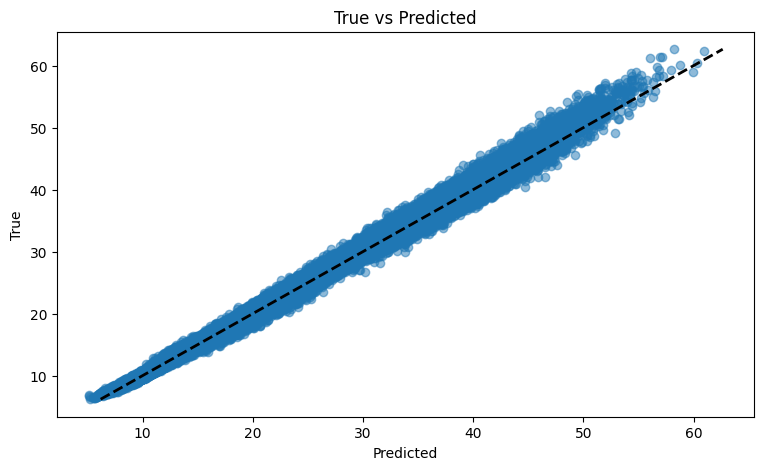

In [16]:
# Plot Y against y_pred
plt.figure(figsize=figsize)
plt.scatter(y_pred_np, Y, alpha=0.5)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('True vs Predicted')
plt.show()